In [ ]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, losses, metrics
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from IPython.display import display
os.environ['TF_DETERMINISTIC_OPS']     = '1'
os.environ['TF_CUDNN_DETERMINISTIC']   = '1'
os.environ['TF_ENABLE_ONEDNN_OPTS']    = '0'

def set_global_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import sys
sys.path.append('src')
from lstm.lstm import (
    load_lstm_weights_from_keras,
    create_lstm_model_from_weights,
    compute_macro_f1_score
)

def load_dataset(base_path: str):
    df_train = pd.read_csv(os.path.join(base_path, 'train.csv'))
    df_val   = pd.read_csv(os.path.join(base_path, 'valid.csv'))
    df_test  = pd.read_csv(os.path.join(base_path, 'test.csv'))
    labels = sorted(df_train['label'].unique())
    label2idx = {l:i for i,l in enumerate(labels)}
    def to_xy(df):
        X = df['text'].astype(str).tolist()
        y = df['label'].map(label2idx).astype(int).tolist()
        return X, y
    return to_xy(df_train), to_xy(df_val), to_xy(df_test)

def build_vectorizer(max_tokens=20000, seq_len=200):
    return layers.TextVectorization(
        max_tokens=max_tokens,
        output_mode='int',
        output_sequence_length=seq_len
    )

def make_tf_dataset(texts, labels, vectorizer, batch_size=64, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((texts, labels))
    if shuffle:
        ds = ds.shuffle(len(texts), seed=42)
    ds = ds.batch(batch_size).map(lambda x,y: (vectorizer(x), y),
                                  num_parallel_calls=tf.data.AUTOTUNE)
    return ds.prefetch(tf.data.AUTOTUNE)

def build_keras_lstm(vocab_size, embedding_dim, seq_len,
                     lstm_units, dropout_rate, bidirectional=False,
                     num_classes=3):
    inp = layers.Input((seq_len,), dtype='int32')
    x = layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(inp)
    for i, u in enumerate(lstm_units):
        ret_seq = (i < len(lstm_units)-1)
        L = layers.LSTM(u, return_sequences=ret_seq)
        if bidirectional:
            L = layers.Bidirectional(L)
        x = L(x)
    x = layers.Dropout(dropout_rate)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    m = models.Model(inp, out)
    m.compile(
        optimizer=optimizers.Adam(),
        loss=losses.SparseCategoricalCrossentropy(),
        metrics=[metrics.SparseCategoricalAccuracy()]
    )
    return m

In [11]:
DATA_DIR   = 'dataset/lstm'
MAX_TOKENS = 20000
SEQ_LEN    = 200
BATCH_SIZE = 64

(train_texts, train_labels), (val_texts, val_labels), (test_texts, test_labels) = load_dataset(DATA_DIR)

vectorizer = build_vectorizer(MAX_TOKENS, SEQ_LEN)
vectorizer.adapt(train_texts)

train_ds = make_tf_dataset(train_texts, train_labels, vectorizer, BATCH_SIZE, shuffle=True)
val_ds   = make_tf_dataset(val_texts,   val_labels,   vectorizer, BATCH_SIZE)
test_seq = vectorizer(np.array(test_texts)).numpy()

,scratch_acc,scratch_f1
config,,
32_units,0.6925,0.602941


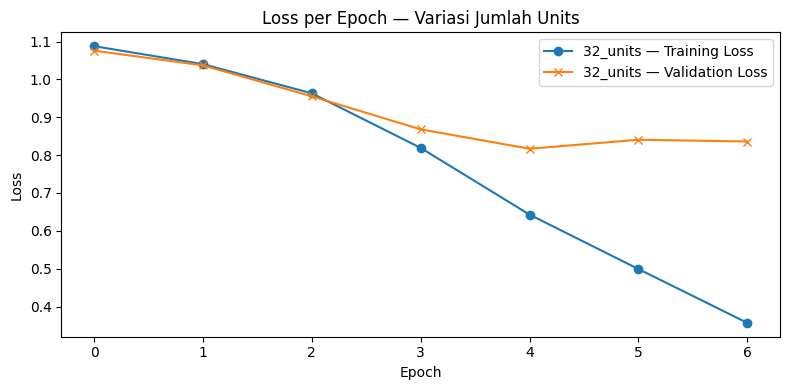

In [12]:
unit_configs = {
    '32_units':[32],
}

unit_results = []
for name, units in unit_configs.items():
    set_global_seed(42)
    K.clear_session()

    vectorizer = build_vectorizer(MAX_TOKENS, SEQ_LEN)
    vectorizer.adapt(train_texts)
    train_ds = make_tf_dataset(train_texts, train_labels, vectorizer,
                               batch_size=BATCH_SIZE, shuffle=True)
    val_ds   = make_tf_dataset(val_texts,   val_labels,   vectorizer,
                               batch_size=BATCH_SIZE, shuffle=False)
    
    model = build_keras_lstm(
        vocab_size=MAX_TOKENS,
        embedding_dim=128,
        seq_len=SEQ_LEN,
        lstm_units=units,
        dropout_rate=0.5,
        bidirectional=False,
        num_classes=len(set(train_labels))
    )
    es = callbacks.EarlyStopping(patience=2, restore_best_weights=True)
    hist = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[es], verbose=0)
    path = f'models/exp_{name}.h5'; 
    model.save(path)
    weights = load_lstm_weights_from_keras(path, bidirectional=False, num_lstm_layers=1)
    scratch = create_lstm_model_from_weights(weights, dropout_rate=0.5)
    preds = np.argmax(scratch.predict(test_seq), axis=1)
    acc = np.mean(preds == np.array(test_labels))
    f1  = compute_macro_f1_score(np.array(test_labels), preds)
    unit_results.append({'config':name, 'scratch_acc':acc, 'scratch_f1':f1, 'history':hist.history})

df_units = pd.DataFrame(unit_results)[['config','scratch_acc','scratch_f1']].set_index('config')
display(df_units)

plt.figure(figsize=(8,4))
for r in unit_results:
    train_loss = r['history']['loss']
    val_loss   = r['history']['val_loss']

    plt.plot(train_loss, marker='o', label=f"{r['config']} — Training Loss")
    plt.plot(val_loss, marker='x', label=f"{r['config']} — Validation Loss")

plt.title("Loss per Epoch — Variasi Jumlah Units")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

